# Module 7 - Wrap-Up Quiz

## Importing Data

In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


In [2]:
data.describe()

,heart-rate,cadence,speed,acceleration,slope
count,38254.000000,38254.000000,38254.000000,38254.000000,38254.000000
mean,141.385616,72.896876,8.203325,-0.002056,0.005646
std,16.562215,25.235907,2.603563,0.225916,0.108174
min,66.000000,0.000000,0.000000,-2.384600,-7.731092
25%,131.000000,73.000000,6.579000,-0.074400,0.000000
50%,142.000000,82.000000,8.297000,0.005800,0.000000
75%,153.000000,87.000000,9.874000,0.083800,0.010134
max,187.000000,107.000000,18.604000,1.311400,14.857143


A detailed description of this dataset is given in the appendix. As a reminder, the problem we are trying to solve with this dataset is to use measurements from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a cyclist power. Power can indeed be recorded via a cycling power meter device, but this device is rather expensive.

## Feature Engineering

### Creating an empty new dataframe

In [16]:
new_data = pd.DataFrame()

### Computing $V_d^3$ and adding it to the new dataframe

In [17]:
new_data['speed^3'] = data['speed'].apply(lambda x: x**3)

### Adding the speed ($V_d$) to the new dataframe

In [18]:
new_data['speed'] = data['speed']

### Computing $\alpha$ (the angle of the slope)

In [19]:
import numpy as np

new_data['alpha'] = data['slope'].apply(np.arctan)

### Computing $\sin\alpha$

In [20]:
new_data['sin(alpha)'] = new_data['alpha'].apply(np.sin)

### Computing $V_d\times\sin\alpha$

In [21]:
new_data['speed*sin(alpha)'] = new_data[['speed', 'sin(alpha)']].apply(np.prod, axis=1)

### Computing $V_d\times a$

In [22]:
new_data['speed*acceleration'] = data[['speed', 'acceleration']].apply(np.prod, axis=1)

Removing negative values

In [23]:
new_data['speed*acceleration'] = new_data['speed*acceleration'].apply(lambda x: x if x>0 else 0.)

### Another way of computing the above values

In [24]:
# build the data matrix
data_linear_model = pd.concat(
    {"speed^3": data["speed"] ** 3,
     "speed": data["speed"],
     "speed*sin(alpha)": data["speed"] * np.sin(np.arctan(data["slope"])),
     "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)},
    axis=1
)
data_linear_model.head()

,speed^3,speed,speed*sin(alpha),speed*acceleration
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050


## Exploring the new dataframe

Dropping 'apha' and 'sin(alpha)' columns

In [25]:
new_data = new_data.drop(columns=['alpha', 'sin(alpha)'])

In [26]:
new_data.head()

,speed^3,speed,speed*sin(alpha),speed*acceleration
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050


In [27]:
new_data.describe()

,speed^3,speed,speed*sin(alpha),speed*acceleration
count,38254.000000,38254.000000,38254.000000,38254.000000
mean,716.713830,8.203325,-0.002710,0.571451
std,631.602968,2.603563,0.249192,1.082863
min,0.000000,0.000000,-1.803089,0.000000
25%,284.760443,6.579000,0.000000,0.000000
50%,571.167214,8.297000,0.000000,0.045422
75%,962.674280,9.874000,0.076831,0.694669
max,6439.008413,18.604000,1.427276,21.015078


## Ridge Model

### Creating the Model

In [65]:
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

# RidgeCV model taken from (441). However, we will not pass any values for alphas as it has not been specified.
# alphas=np.logspace(-3, 3, num=101)
# default alpha values are 0.1, 1, 10.

ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(store_cv_values=True)
)

cv = ShuffleSplit(n_splits=4, random_state=0)

cv_results_ridge = cross_validate(
    ridge,
    data_linear_model,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True,
    n_jobs=2,
)

### Inspecting Test Scores

In [66]:
errors = -cv_results_ridge["test_score"]
print(f"MAE on test sets:\n{errors}\n",
      f"mean ± std: {errors.mean():.3f} ± {errors.std():.3f} Watts")

MAE on test sets:
[73.23006461 72.1311734  72.89061823 71.2370263 ]
 mean ± std: 72.372 ± 0.767 Watts


### Inspecting Coefficients

In [49]:
coef_df = pd.DataFrame()

for i, pipe in enumerate(cv_results_ridge['estimator']):
    
    coef_df[f'split_{i}'] = pipe[-1].coef_

coef_df.index = [f"β_{i}" for i in range(1,5)]
coef_df

,split_0,split_1,split_2,split_3
β_1,5.118031,6.584509,6.102750,5.673831
β_2,33.099965,31.978694,32.818613,33.215401
β_3,80.523894,80.904793,80.616991,80.794720
β_4,11.274805,11.248154,11.062675,10.648553


All weights are greater than 0. It is not surprising since the coefficients are related to products of positive physical quantities such as the mass of the rider and the bike, gravity, the air density, etc. Indeed, by putting together the first equation and the value of βs, we would expect a relationship that could be close to:
* $\beta_{1} \frac{1}{2} \rho\cdot S\cdot C_x$
* $\beta_{2} C_r\cdot mg$
* $\beta_{3} mg$
* $\beta_{4} ma$

This relationship is also explaining why we could have expected $β_1<β_2<β_3$. Indeed, $C_r$ is a small constant so, we could expect $β_2<β_3$. $ρ.S.C_x$ are very small values in comparison with $C_r$ or $mg$ and one could have expected $β_1<β_2$.

We can plot the weights distribution with a box plot with the following snippet:

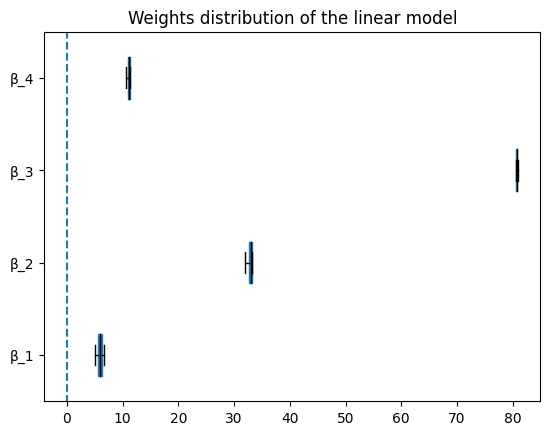

In [58]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}

ax = coef_df.T.plot.box(vert=False, patch_artist=True, color=color)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")


## HistGradientBoostingRegressor Model

### Creating Model

In [63]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True, random_state=42)

cv_results_hgbdt = cross_validate(
    hgbdt,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
)

In [64]:
errors = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n{errors}\n",
      f"mean ± std: {errors.mean():.3f} ± {errors.std():.3f} Watts")

MAE on test sets:
[43.55378572 42.75288357 43.88061106 43.73794308]
 mean ± std: 43.481 ± 0.436 Watts


### Ridge vs HGBR

To compare, we need to print the train and test error for both models:

In [70]:
errors_SS_lm = -cv_results_ridge["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_SS_lm.mean():.3f} ± {errors_SS_lm.std():.3f} Watts")
errors_SS_lm = -cv_results_ridge["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_SS_lm.mean():.3f} ± {errors_SS_lm.std():.3f} Watts")

errors_SS_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} ± {errors_SS_hgbdt.std():.3f} Watts")
errors_SS_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} ± {errors_SS_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.479 ± 0.096 Watts
Linear model - MAE on test sets:	 72.372 ± 0.767 Watts
Histogram GBDT - MAE on train sets:	 40.621 ± 0.581 Watts
Histogram GBDT - MAE on test sets:	 43.481 ± 0.436 Watts


With the histogram gradient boosting, the testing error is higher than thetraining error. This symptomatic of a model capable of overfitting. The testing and training error of the linear model are very close. However, the errors are much higher than the histogram gradient boosting. The linear model is clearly underfitting.

## Grouping

### Number of Rides

In the previous cross-validation, we made the choice of using a `ShuffleSplit` cross-validation strategy. It means that randomly selected samples were selected as testing set ignoring any time dependency between the lines of the dataframe.

We would like to have a cross-validation strategy that takes into account the groups defined by each individual date. Each group corresponds to a bike ride.

To check the number of bike rides stored in the dataframe `data`, we can check the unique day in the `DatetimeIndex` (the index of the dataframe `data`). Indeed, we assume that on a given day the rider went cycling at most once per day.

We can access to the date and time of a `DatetimeIndex` using `df.index.date` and `df.index.time`, respectively.

The following code snippet allows to count the number of different days appearing in the index of the dataframe.


In [79]:
unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


Another way,

In [80]:
unique_ride_dates = data.index.normalize().unique()
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


### LeaveOneGroupOut

Creating groups and CV splits,

For groups, we use `pd.factorize`. For more info, read [the documentation](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html#pandas.factorize).

In [92]:
from sklearn.model_selection import LeaveOneGroupOut

groups, uniques = pd.factorize(data.index.date)

logo = LeaveOneGroupOut()

Re-evaluating RidgeCV,

In [93]:
cv_results_ridge_logo = cross_validate(
    ridge,
    data_linear_model,
    target,
    cv=logo,
    groups=groups,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
)

In [94]:
errors_SS_lm = -cv_results_ridge_logo["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_SS_lm.mean():.3f} ± {errors_SS_lm.std():.3f} Watts")
errors_SS_lm = -cv_results_ridge_logo["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_SS_lm.mean():.3f} ± {errors_SS_lm.std():.3f} Watts")

Linear model - MAE on train sets:	 72.249 ± 2.247 Watts
Linear model - MAE on test sets:	 73.015 ± 5.779 Watts


Re-evaluating HGBR,

In [95]:
cv_results_hgbdt_logo = cross_validate(
    hgbdt,
    data,
    target,
    cv=logo,
    groups=groups,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1,
)

In [96]:

errors_SS_hgbdt = -cv_results_hgbdt_logo["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} ± {errors_SS_hgbdt.std():.3f} Watts")
errors_SS_hgbdt = -cv_results_hgbdt_logo["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} ± {errors_SS_hgbdt.std():.3f} Watts")

Histogram GBDT - MAE on train sets:	 40.131 ± 1.295 Watts
Histogram GBDT - MAE on test sets:	 49.204 ± 2.694 Watts


Regarding model under- and over-fitting, we observe the same behaviour as with the ShuffleSplit strategy: the linear model is still limited by underfitting while the histogram gradient boosting regressor is still overfitting.

We also see that the histogram gradient boosting regressor is more clearly overfitting with the `LeaveOneGroupOut` cross-validation strategy as the gap between train and test scores is even wider than measured with the `ShuffleSplit` strategy.

Thus, even if the linear model is modelling the true physical problem, it probably suffers from shortcomings imposed by missing measurements (for instance wind speed) and by the uncertainty of some measurements (for instance GPS error). As a result, the linear model is not as accurate as the histogram gradient boosting regressor that has access to external measurements. The additional information, such as the heart-rate and the cadence, attenuate the previous shortcomings.

`ShuffleSplit` estimates a lower generalization error than the error measured by `LeaveOneGroupOut` for the gradient boosting model.
The `LeaveOneGroupOut` strategy is closer to the actual setting encountered when putting the model in production, we can conclude that the generalization performance provided by the `ShuffleSplit` cross-validation strategy was over-optimistic by estimating a lower average test error than what we would observe on future bike rides.

It is interesting to note that we do not see this behaviour for the linear model. The reason is that our linear model is underfitting.

We observe a higher standard deviation of the test MAE when it is computed by respecting the ride dependency structure using `LeaveOneGroupOut`: we can see that the third fold has a low train error and a much higher test error than for the other folds.

The reason can be found by plotting histograms of the target variable independently for each ride and observe that one ridge has significantly higher power values with a long and steep slope.

## Train/Test Split

Now, we will go more into details by picking a single ride for the testing and analyse the predictions of the models for this test ride. To do so, we can reuse the `LeaveOneGroupOut` cross-validation object in the following manner:

In [119]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

Fit both models,

In [120]:
ridge.fit(data_linear_model_train, target_train)
hgbdt.fit(data_train, target_train)

HistGradientBoostingRegressor(early_stopping=True, max_iter=1000,
                              random_state=42)

Predict values,

In [121]:
ridge_predictions = ridge.predict(data_linear_model_test)
hgbdt_predictions = hgbdt.predict(data_test)

Plot predictions vs. truth for both models,

Text(0, 0.5, 'Predicted power (Watts)')

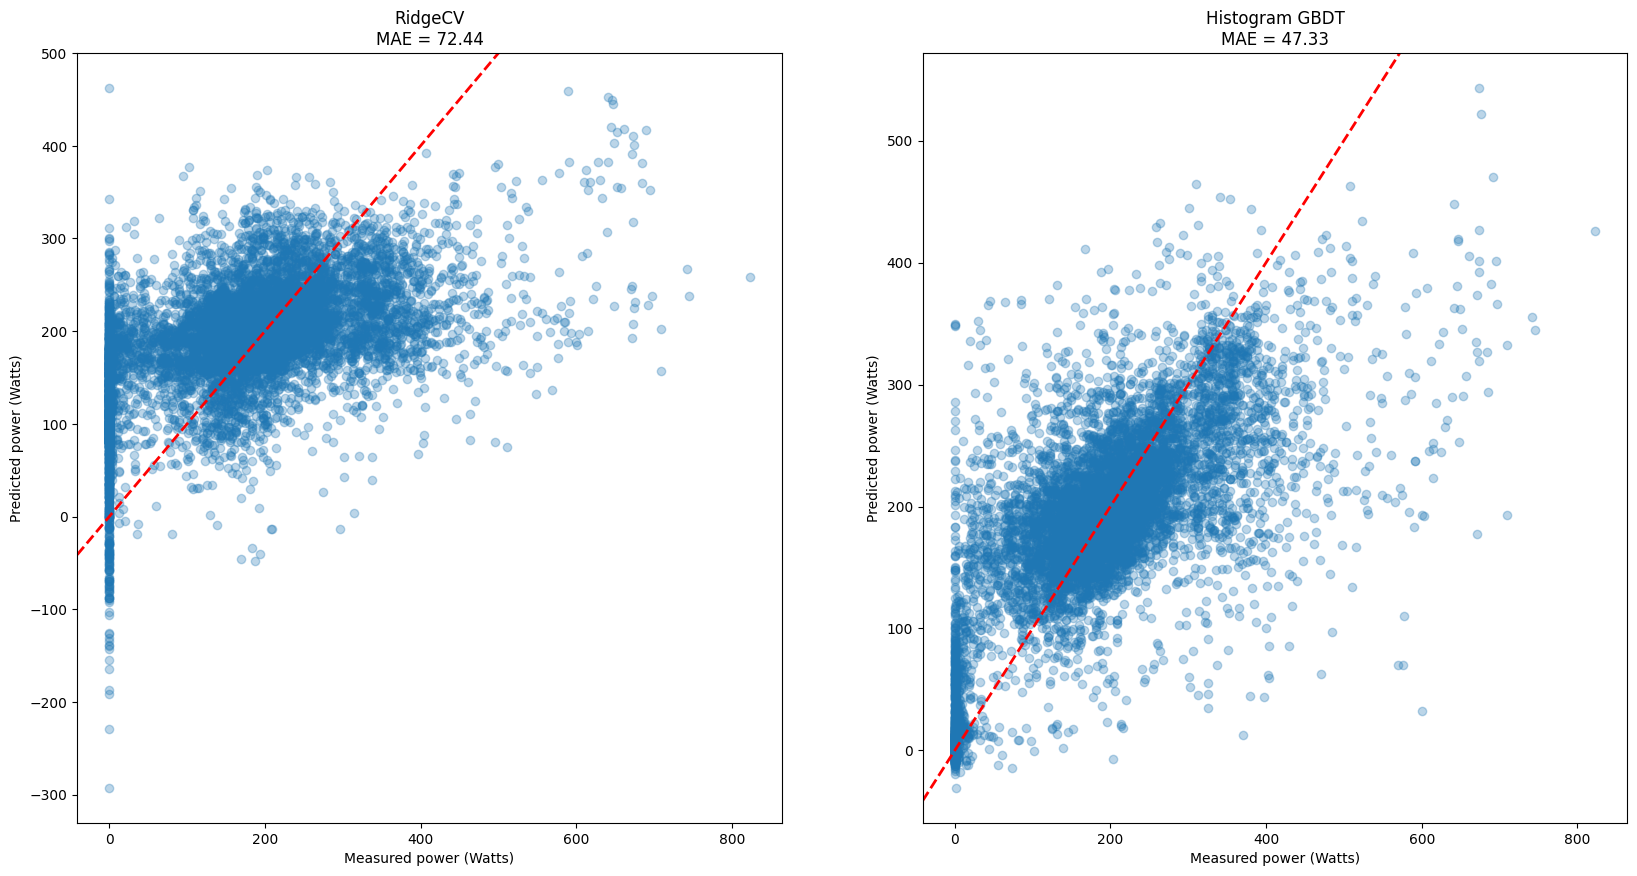

In [124]:
from sklearn.metrics import mean_absolute_error

mae_ridge = mean_absolute_error(target_test, ridge_predictions)
mae_hgbdt = mean_absolute_error(target_test, hgbdt_predictions)

fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].scatter(x=target_test, y=ridge_predictions, alpha=.3)
ax[0].axline((0, 0), (1, 1), linestyle="--", linewidth=2, color='r')
ax[0].set_title(f'RidgeCV\nMAE = {mae_ridge:.2f}')
ax[0].set_xlabel('Measured power (Watts)')
ax[0].set_ylabel('Predicted power (Watts)')

ax[1].scatter(x=target_test, y=hgbdt_predictions, alpha=.3)
ax[1].axline((0, 0), (1, 1), linestyle="--", linewidth=2, color='r')
ax[1].set_title(f'Histogram GBDT\nMAE = {mae_hgbdt:.2f}')
ax[1].set_xlabel('Measured power (Watts)')
ax[1].set_ylabel('Predicted power (Watts)')


Let's start by looking at the samples with high power. We see that both the linear model and the histogram gradient boosting regressor always predict power below the measured power. Indeed, high power samples correspond to sprints effort. When measuring speed and acceleration, there is a sort of delay to observe this change while measuring the power directly apply on the pedals will not suffer from such issue.

On the other hand, we see that the linear model predicts catastrophic negative power for samples with a power of 0 Watt. This is due to our modeling. Indeed, the power based on the change of kinetic energy (power needed to accelerate or decelerate) is producing such artifacts. Indeed, we do not model the power loss introduced by heat dissipation when braking to reduce the speed of the bike (to take a bend for instance) and therefore, we get non-sense value for samples with low power. The histogram gradient boosting regressor uses instead the cadence since 0 rpm (rotation per minute) will be linked with 0 Watt produced.

## Time Slice Subset

Now select a portion of the testing data using the following code:

In [123]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

It allows to select data from 5.00 pm until 5.05 pm. We use the previous fitted models (linear and gradient-boosting regressor) to predict on this portion of the test data.

We draw on the same plot the true targets and the predictions of each model.

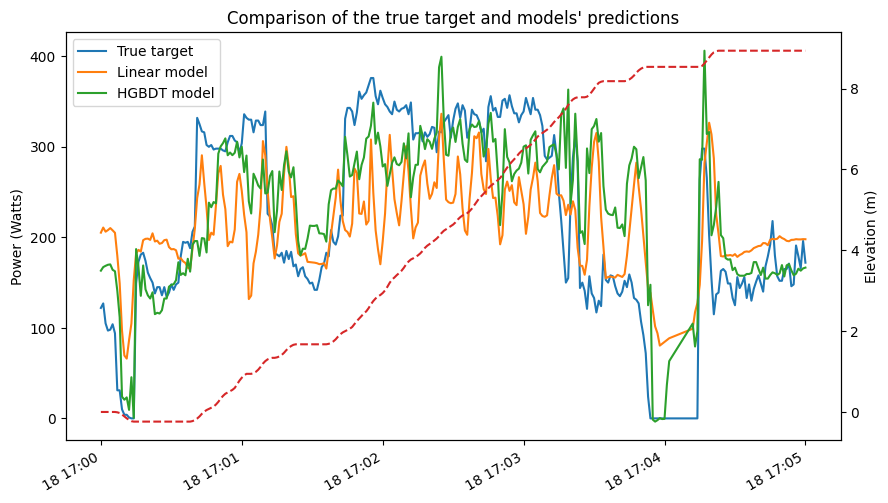

In [127]:
target_predicted_linear_model = ridge.predict(data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model, label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a hill.
# This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")

We see that the linear model has predictions that are more off from the true target than the predictions from the histogram gradient boosting regressor. While the histogram gradient boosting regressor is able to make abrupt changes of the power, the linear model is unable to predict abrupt changes and need time to output the level of true power.

Again the comparatively bad performance of the linear regression model trained on the physically meaningful features does not necessarily stem from errors in the feature engineering but might come from the GPS measurement errors that prevent a precise estimation of short changes in the speed and acceleration.

The gradient boosting model might be able to workaround those limitations of the GPS errors via the more precise heart rate and cadence measurements.